# **IMPORTING NECESSARY LIBRARIES**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score

# **LOADING DATASET**

In [3]:
df=pd.read_csv('/content/loan_data.csv')

# **DATA PREPROCESSING**

In [4]:
le=LabelEncoder()
df['person_gender']=le.fit_transform(df['person_gender'])
df['previous_loan_defaults_on_file']=le.fit_transform(df['previous_loan_defaults_on_file'])

In [5]:
education_ordinal = {
    'High School': 0,
    'Associate': 1,
    'Bachelor': 2,
    'Master': 3,
    'Doctorate': 4
}
df['education_ordinal'] = df['person_education'].map(education_ordinal)

In [6]:
df.drop('person_education',axis=1,inplace=True)

In [7]:
home_ownership_dummies = pd.get_dummies(df['person_home_ownership'], prefix='home', drop_first=True)
df = pd.concat([df, home_ownership_dummies], axis=1)
df.drop('person_home_ownership', axis=1, inplace=True)
df['home_OTHER'] = df['home_OTHER'].astype(int)
df['home_OWN'] = df['home_OWN'].astype(int)
df['home_RENT'] = df['home_RENT'].astype(int)

In [8]:
loan_intent_dummies = pd.get_dummies(df['loan_intent'], prefix='intent', drop_first=True)
df = pd.concat([df, loan_intent_dummies], axis=1)
df.drop('loan_intent', axis=1, inplace=True)
df[loan_intent_dummies.columns] = df[loan_intent_dummies.columns].astype(int)

# **OUTLIER ANALYSIS**

In [9]:
num_cols = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate',
            'loan_percent_income', 'cb_person_cred_hist_length']
z_scores = df[num_cols].apply(zscore)
outlier_flags = (z_scores.abs() > 3)
outlier_rows = df[outlier_flags.any(axis=1)]
print(f"Total outliers detected: {outlier_rows.shape[0]}")

Total outliers detected: 1911


In [10]:
df2 = df[~outlier_flags.any(axis=1)].reset_index(drop=True)

In [11]:
print(f"After removing outliers: {df2.shape}")

After removing outliers: (43089, 20)


In [12]:
df2['loan_status'].value_counts()

,count
loan_status,
0,33808
1,9281


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43089 entries, 0 to 43088
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      43089 non-null  float64
 1   person_gender                   43089 non-null  int64  
 2   person_income                   43089 non-null  float64
 3   person_emp_exp                  43089 non-null  int64  
 4   loan_amnt                       43089 non-null  float64
 5   loan_int_rate                   43089 non-null  float64
 6   loan_percent_income             43089 non-null  float64
 7   cb_person_cred_hist_length      43089 non-null  float64
 8   credit_score                    43089 non-null  int64  
 9   previous_loan_defaults_on_file  43089 non-null  int64  
 10  loan_status                     43089 non-null  int64  
 11  education_ordinal               43089 non-null  int64  
 12  home_OTHER                      

# **FEATURE SELECTION USING HEATMAP**

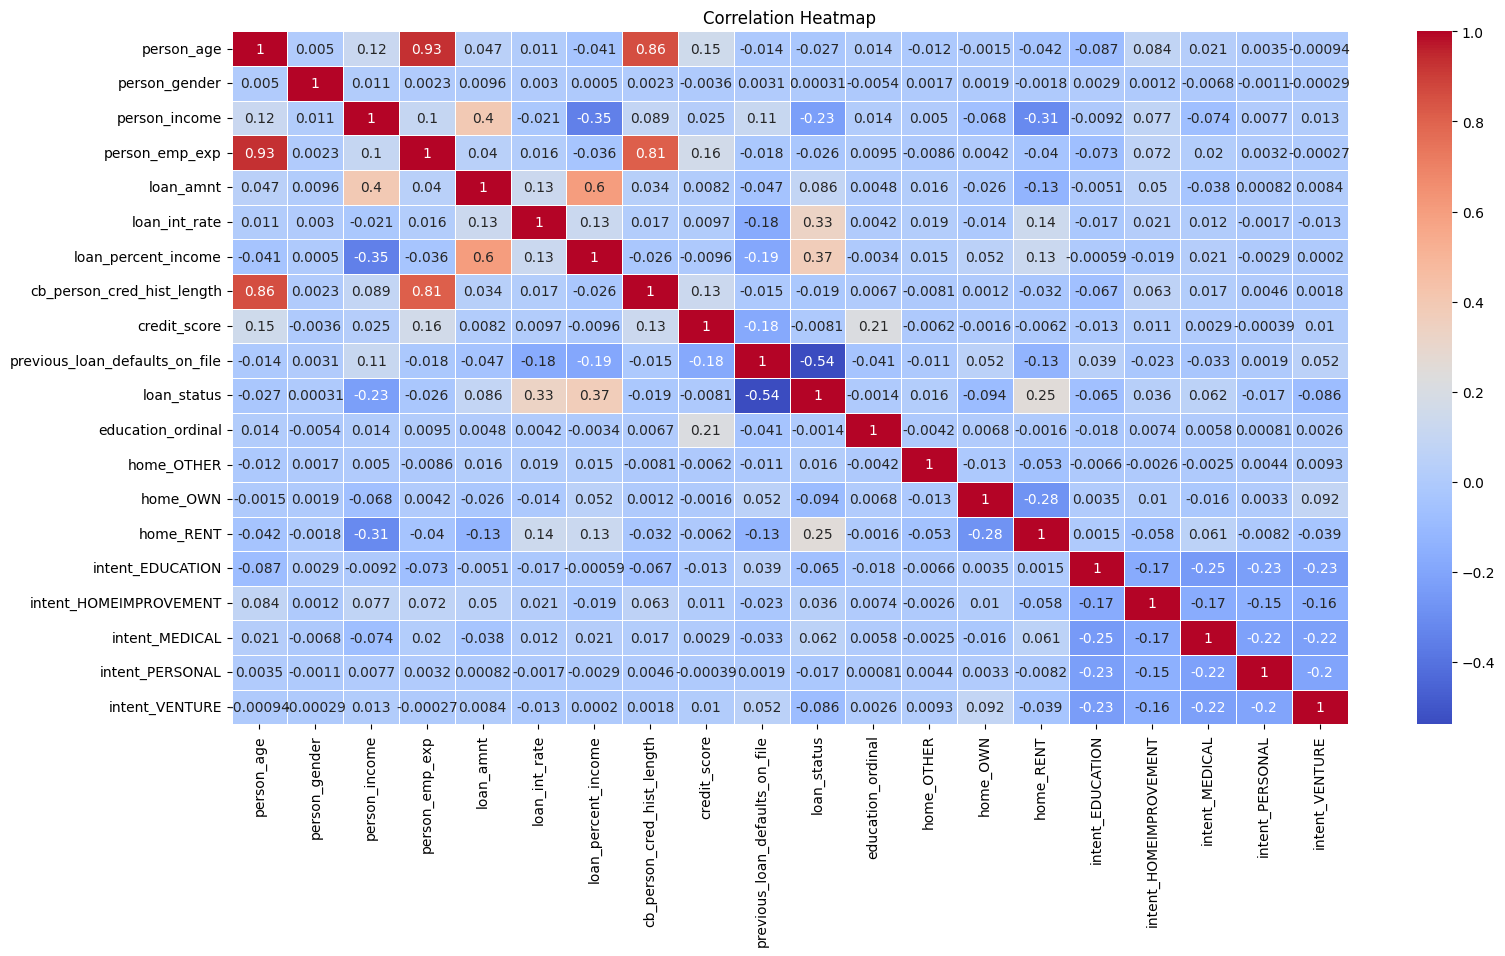

In [14]:
plt.figure(figsize=(18, 9))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', linewidths=0.5 )
plt.title('Correlation Heatmap')
plt.show()

# **HANDLING IMBALANCE USING SMOTENC**

In [15]:
final_features = [
    'person_emp_exp',
    'loan_int_rate',
    'home_RENT',
    'loan_percent_income'
]

In [16]:
X=df2[final_features]
y=df2['loan_status']

In [17]:
categorical_idx = [X.columns.get_loc('home_RENT')]

smote = SMOTENC(categorical_features=categorical_idx, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **MODEL TRAINING WITH HYPERPARAMETER TUNING**

🔹 Best Parameters: {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}

🔸 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      6728
           1       0.87      0.83      0.85      6796

    accuracy                           0.85     13524
   macro avg       0.85      0.85      0.85     13524
weighted avg       0.85      0.85      0.85     13524

✅ TRAINING Accuracy: 0.899227242475782
✅ TESTING Accuracy: 0.8519668737060041


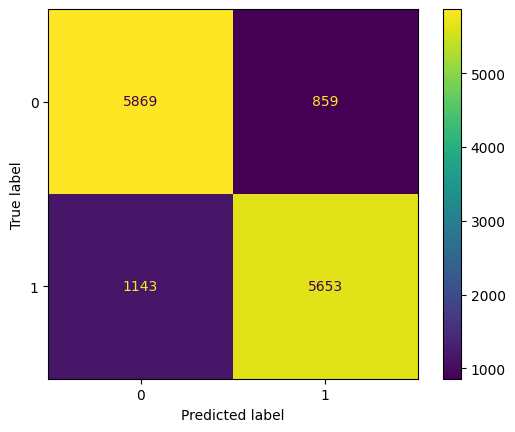

In [18]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8, 10, 12, 16],
    'min_samples_split': [1,2, 5],
    'min_samples_leaf': [1, 3,2]
}
dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt, param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_dt.fit(X_train, y_train)
print("🔹 Best Parameters:", grid_dt.best_params_)
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("\n🔸 Classification Report:\n", classification_report(y_test, y_pred_dt))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dt)).plot()
print("✅ TRAINING Accuracy:", best_dt.score(X_train, y_train))
print("✅ TESTING Accuracy:", best_dt.score(X_test, y_test))


# **PREDICTION**

In [20]:
user_input = {
    "person_emp_exp": int(input("Enter your experience : ")),
    "loan_int_rate": float(input("Loan Interest Rate (%): ")),
    "home_RENT": int(input("Home Ownership (RENT=1, else 0): ")),
    "loan_percent_income": float(input("Loan % of Income (e.g. 0.25): "))
}
prediction=best_dt.predict(pd.DataFrame([user_input]))
if prediction==0:
  print('🟩 CONGRATS!!! YOUR LOAN WAS APPROVED')
else:
  print('🟥 SORRY!!! YOUR LOAN WAS REJECTED')

Enter your experience : 1
Loan Interest Rate (%): 0.12
Home Ownership (RENT=1, else 0): 1
Loan % of Income (e.g. 0.25): 0.32
🟥 SORRY!!! YOUR LOAN WAS REJECTED
